In [1]:
import IO
#from dff_helper import process_dff_trials
from pathlib import Path


In [2]:
def load_config(config_path: str | Path) -> dict:
    config_path = Path(config_path)
    with config_path.open("r") as f:
        cfg = yaml.safe_load(f)
    return cfg

import yaml

cfg = load_config(r"C:\Users\tobiasleva\Work\WF_analysis\wf_analysis\config_example.yaml")

dataset_id = cfg["dataset_id"]
session_id = cfg["session_id"]
protocol_list = cfg["protocols"]

raw_root = cfg["paths"]["raw_root"]
processed_root = cfg["paths"]["processed_root"]

dff_cfg = cfg["dff"]
roi_cfg = cfg["roi"]
trace_cfg = cfg["trace"]

dataset_id = cfg["dataset_id"]
session_id = cfg["session_id"]
protocol_list = cfg["protocols"]

raw_root = cfg["paths"]["raw_root"]
processed_root = cfg["paths"]["processed_root"]

dff_cfg = cfg["dff"]
roi_cfg = cfg["roi"]
trace_cfg = cfg["trace"]

In [3]:
start =  cfg["stimulus"]["start"]
end =  cfg["stimulus"]["end"]

In [18]:
stim_start = cfg["roi"]["frame_start"]
stim_end = cfg["roi"]["frame_end"]

In [4]:
from pathlib import Path
import numpy as np
from typing import List, Dict, Any


def load_all_dffs_for_session(
    dataset_id: str,
    session_id: str,
    processed_root: str | Path,
    protocol_list: list[str] | None = None,
    load_arrays: bool = True,
) -> List[Dict[str, Any]]:
    """
    Load all DFF movies for a given animal + session.

    Matches exactly how the dF/F stage writes data:
        processed_root/dataset/session/protocol/trial_id/dff.npy

    Parameters
    ----------
    dataset_id : str
        Animal ID, e.g. "JPCM-08704"
    session_id : str
        Session ID, e.g. "250905_leica"
    processed_root : str or Path
        Root processed directory
    protocol_list : list[str] or None
        If None, auto-discover protocols
    load_arrays : bool
        If False, only paths + metadata are returned

    Returns
    -------
    entries : list of dict
        Each dict contains:
            {
                "protocol": str,
                "trial_id": str,
                "path": Path,
                "dff": np.ndarray | None
            }
    """

    processed_root = Path(processed_root)
    session_dir = processed_root / dataset_id / session_id

    if not session_dir.exists():
        raise FileNotFoundError(f"Session not found: {session_dir}")

    # Auto-discover protocols if not provided
    if protocol_list is None:
        protocol_list = sorted(
            p.name for p in session_dir.iterdir() if p.is_dir()
        )

    entries: List[Dict[str, Any]] = []

    for protocol in protocol_list:
        proto_dir = session_dir / protocol
        if not proto_dir.exists():
            continue

        for dff_path in sorted(proto_dir.glob("*/dff.npy")):
            trial_id = dff_path.parent.name

            entry = {
                "protocol": protocol,
                "trial_id": trial_id,
                "path": dff_path,
                "dff": None,
            }

            if load_arrays:
                entry["dff"] = np.load(dff_path)

            entries.append(entry)

    if not entries:
        print("⚠️ No dff.npy files found.")

    return entries


In [5]:
entries = load_all_dffs_for_session(
    dataset_id=dataset_id,
    session_id=session_id,
    processed_root=processed_root,
)

In [13]:
movies = [entries[i]["dff"] for i in range(len(entries))]

In [14]:
from IO import read_trial_data
from utils import group_trials_by_stimulus

res_list = read_trial_data(
    dataset_id="JPCM-08704",
    session_id="250905_leica",
    base_dir=raw_root,
    protocol_list=protocol_list,
)

# 2) Group trials by stimulus
stim_groups = group_trials_by_stimulus(
    res_list=res_list,
    dffs=movies,
    start = 5000,
    end=7000    
)


--- Reading protocol: 22_42_interleaved ---
Reading 250905_133500 (Z:\Individual_Folders\Tobi\WF_axonimaging\axonal_imaging_tobi\data\raw/JPCM-08704/250905_leica/22_42_interleaved\250905_133500\data.h5)
Reading 250905_133530 (Z:\Individual_Folders\Tobi\WF_axonimaging\axonal_imaging_tobi\data\raw/JPCM-08704/250905_leica/22_42_interleaved\250905_133530\data.h5)
Reading 250905_133600 (Z:\Individual_Folders\Tobi\WF_axonimaging\axonal_imaging_tobi\data\raw/JPCM-08704/250905_leica/22_42_interleaved\250905_133600\data.h5)
Reading 250905_133630 (Z:\Individual_Folders\Tobi\WF_axonimaging\axonal_imaging_tobi\data\raw/JPCM-08704/250905_leica/22_42_interleaved\250905_133630\data.h5)
Reading 250905_133700 (Z:\Individual_Folders\Tobi\WF_axonimaging\axonal_imaging_tobi\data\raw/JPCM-08704/250905_leica/22_42_interleaved\250905_133700\data.h5)
Reading 250905_133730 (Z:\Individual_Folders\Tobi\WF_axonimaging\axonal_imaging_tobi\data\raw/JPCM-08704/250905_leica/22_42_interleaved\250905_133730\data.h5)
R

In [107]:
data = stim_groups[42.0]['dff_mean'][stim_start:stim_end,:,:].mean(axis=0)

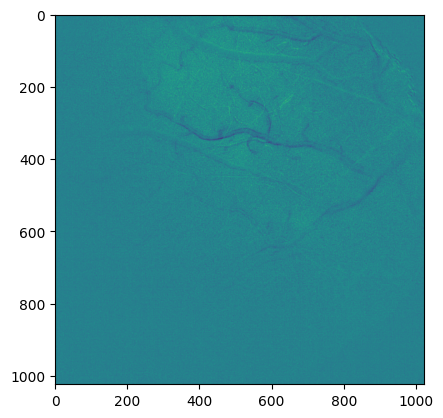

In [108]:
import matplotlib.pyplot as plt
plt.imshow(data)

In [109]:
def gaussian_smooth_2d(arr, sigma):
    """
    Apply 2D Gaussian smoothing to an array.

    Handles:
        - 2D arrays  (H, W)
        - 3D arrays  (T, H, W), smoothing only in spatial dimensions

    Parameters
    ----------
    arr : np.ndarray
        Input array, either (H, W) or (T, H, W).
    sigma : float or tuple
        Standard deviation of Gaussian kernel in pixels.
        If float → same sigma for H and W

    Returns
    -------
    smoothed : np.ndarray
        Same shape as input.
    """

    arr = np.asarray(arr)

    if arr.ndim == 2:
        # simple 2D smoothing
        return gaussian_filter(arr, sigma=sigma)

    elif arr.ndim == 3:
        # smooth each frame independently
        T = arr.shape[0]
        out = np.zeros_like(arr)

        for t in range(T):
            out[t] = gaussian_filter(arr[t], sigma=sigma)

        return out

    else:
        raise ValueError("Input must be 2D (H,W) or 3D (T,H,W).")

In [110]:
from scipy.ndimage import gaussian_filter

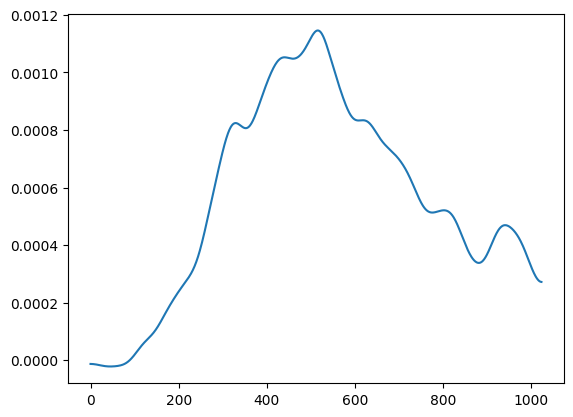

In [112]:
plt.plot(gaussian_smooth_2d(data,20).mean(axis=0))

In [118]:
data_smooth = gaussian_smooth_2d(data,20)

In [119]:
percentile=80

In [120]:
thr = np.percentile(data_smooth.ravel(), percentile)

In [121]:
data_mask = data_smooth.copy()
data_mask[data_mask<thr] = 0
data_mask[data_mask>thr] = 1

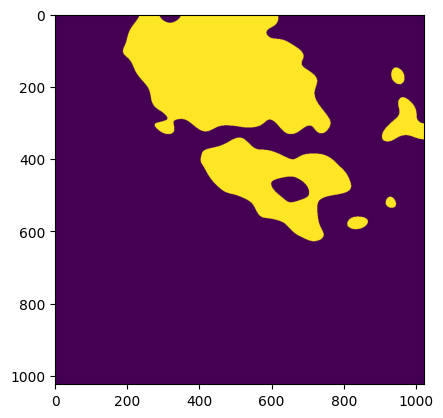

In [122]:
plt.imshow(data_mask)

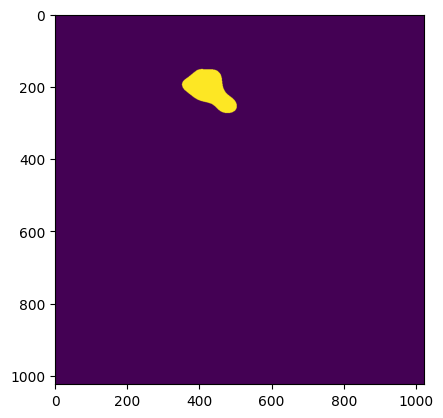

In [106]:
plt.imshow(data_mask)

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.gridspec import GridSpec


def plot_percentile_contours_with_marginals(
    dff_mean: np.ndarray,
    frame_start: int = 100,
    frame_end: int = 140,
    smooth_sigma: float = 8.0,
    thr_values=None,
    normalize: bool = True,
):
    """
    Plot percentile-based contour maps using the same thresholding logic
    as ROI estimation, with marginal mean projections.

    Parameters
    ----------
    dff_mean : np.ndarray
        Mean DFF movie, shape (T, H, W)
    frame_start, frame_end : int
        Frames used to compute the activation map
    smooth_sigma : float
        Gaussian smoothing sigma
    thr_values : None | float | list | np.ndarray
        Percentile threshold(s).
        - None        → defaults to range(80, 100)
        - float/int   → single percentile (e.g. 95)
        - list/array  → multiple percentiles (e.g. [80, 90, 95, 99])
    normalize : bool
        If True, scale activation map to [0, 1]
    """

    # -------------------------
    # Threshold handling
    # -------------------------
    if thr_values is None:
        percentiles = list(range(80, 100))
    elif np.isscalar(thr_values):
        percentiles = [float(thr_values)]
    else:
        percentiles = [float(p) for p in thr_values]

    # -------------------------
    # Activation map (same as ROI stage)
    # -------------------------
    act_map = dff_mean[frame_start:frame_end].mean(axis=0)
    smooth_map = gaussian_filter(act_map, sigma=smooth_sigma)

    if normalize:
        vmin, vmax = smooth_map.min(), smooth_map.max()
        if vmax > vmin:
            smooth_map = (smooth_map - vmin) / (vmax - vmin)
        else:
            smooth_map = np.zeros_like(smooth_map)

    H, W = smooth_map.shape

    # -------------------------
    # Marginals
    # -------------------------
    mean_x = smooth_map.mean(axis=0)
    mean_y = smooth_map.mean(axis=1)

    # -------------------------
    # Figure layout
    # -------------------------
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(
        2, 2,
        width_ratios=(4, 1),
        height_ratios=(1, 4),
        wspace=0.05,
        hspace=0.05,
    )

    ax_top = fig.add_subplot(gs[0, 0])
    ax_main = fig.add_subplot(gs[1, 0])
    ax_right = fig.add_subplot(gs[1, 1])

    # -------------------------
    # Main image
    # -------------------------
    im = ax_main.imshow(smooth_map, origin="upper")
    ax_main.set_title("Percentile contour thresholds")
    ax_main.set_xticks([])
    ax_main.set_yticks([])

    # -------------------------
    # Contours
    # -------------------------
    for p in percentiles:
        thr = np.percentile(smooth_map.ravel(), p)
        ax_main.contour(
            smooth_map,
            levels=[thr],
            linewidths=1,
            alpha=0.8,
        )

    # -------------------------
    # Marginal plots
    # -------------------------
    ax_top.plot(mean_x)
    ax_top.set_xlim(0, W)
    ax_top.axis("off")
    ax_top.set_title("Mean over Y")

    ax_right.plot(mean_y, np.arange(H))
    ax_right.set_ylim(H, 0)
    ax_right.axis("off")
    ax_right.set_title("Mean over X", rotation=-90, x=1.2, y=0.5)

    # -------------------------
    # Colorbar
    # -------------------------
    cbar = fig.colorbar(im, ax=ax_main, fraction=0.046, pad=0.04)
    cbar.set_label("Normalized ΔF/F")

    plt.show()


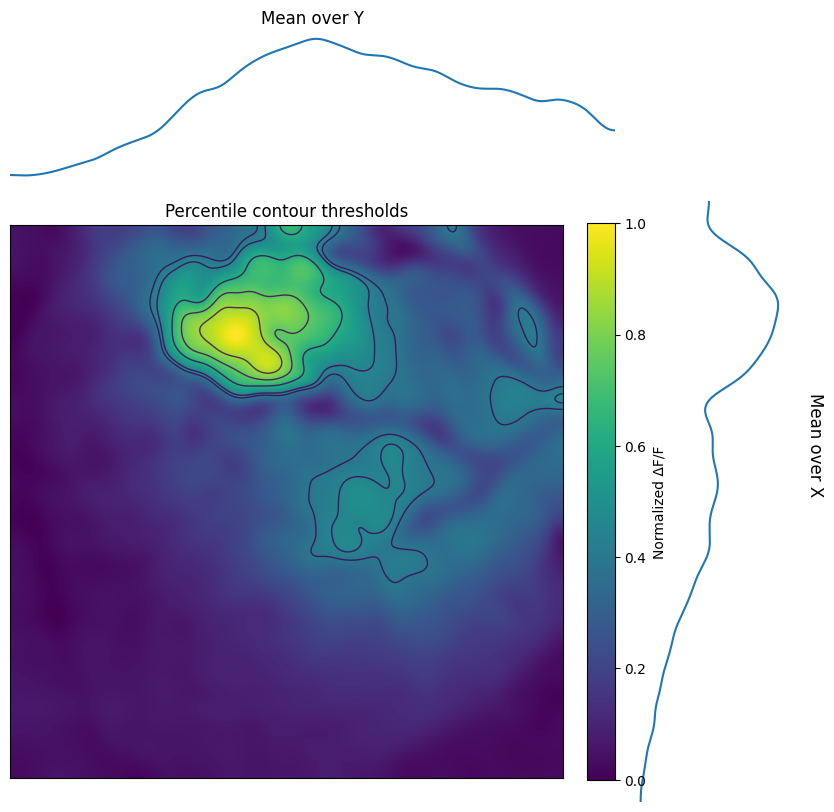

In [130]:


plot_percentile_contours_with_marginals(
    dff_mean=stim_groups[22.0]["dff_mean"],
    frame_start=100,
    frame_end=140,
    smooth_sigma=20,
    thr_values=[85, 90, 95, 97.5, 99],
)


In [135]:
import numpy as np

def temporal_moving_average(movie: np.ndarray, window: int = 1):
    """
    Apply temporal moving average to a movie.

    Parameters
    ----------
    movie : np.ndarray
        Array of shape (T, H, W)
    window : int
        Window size in frames. If 1, returns movie unchanged.

    Returns
    -------
    movie_smooth : np.ndarray
        Smoothed movie, same shape as input
    """
    if window <= 1:
        return movie

    T, H, W = movie.shape
    out = np.zeros_like(movie)

    half = window // 2

    for t in range(T):
        t0 = max(0, t - half)
        t1 = min(T, t + half + 1)
        out[t] = movie[t0:t1].mean(axis=0)

    return out


import numpy as np
import matplotlib.pyplot as plt
import imageio
from scipy.ndimage import gaussian_filter


def make_dff_contour_video(
    dff_movie: np.ndarray,
    output_path: str,
    smooth_sigma: float = 8.0,
    thr_values=None,
    temporal_window: int = 1,
    normalize: bool = True,
    fps: int = 10,
):
    """
    Create a video of ΔF/F frames with overlaid percentile-based contours.
    Contour thresholds are computed once over the entire video.

    Parameters
    ----------
    dff_movie : np.ndarray
        ΔF/F movie, shape (T, H, W)
    output_path : str
        Path to output video file (e.g. 'dff_contours.mp4')
    smooth_sigma : float
        Spatial Gaussian smoothing sigma (used for threshold computation)
    thr_values : None | float | list
        Percentile threshold(s).
        - None      → defaults to [80..99]
        - scalar    → single percentile
        - list      → multiple percentiles
    temporal_window : int
        Window size (frames) for temporal moving average
    normalize : bool
        Normalize each frame to [0, 1] for display
    fps : int
        Frames per second for output video
    """

    # -------------------------
    # Threshold handling
    # -------------------------
    if thr_values is None:
        percentiles = list(range(80, 100))
    elif np.isscalar(thr_values):
        percentiles = [float(thr_values)]
    else:
        percentiles = [float(p) for p in thr_values]

    # -------------------------
    # Temporal smoothing
    # -------------------------
    dff_movie = temporal_moving_average(dff_movie, window=temporal_window)

    T, H, W = dff_movie.shape

    # -------------------------
    # Compute global activation map (for thresholds)
    # -------------------------
    mean_map = dff_movie.mean(axis=0)
    smooth_map = gaussian_filter(mean_map, sigma=smooth_sigma)

    if normalize:
        vmin, vmax = smooth_map.min(), smooth_map.max()
        if vmax > vmin:
            smooth_map = (smooth_map - vmin) / (vmax - vmin)
        else:
            smooth_map = np.zeros_like(smooth_map)

    contour_levels = [
        np.percentile(smooth_map.ravel(), p) for p in percentiles
    ]

    # -------------------------
    # Figure setup
    # -------------------------
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_axis_off()

    writer = imageio.get_writer(
        output_path,
        fps=fps,
        codec="libx264",
    )

    # -------------------------
    # Frame loop
    # -------------------------
    for t in range(T):
        ax.clear()
        ax.set_axis_off()

        frame = dff_movie[t]

        if normalize:
            fmin, fmax = frame.min(), frame.max()
            if fmax > fmin:
                frame = (frame - fmin) / (fmax - fmin)
            else:
                frame = np.zeros_like(frame)

        im = ax.imshow(frame, origin="upper")

        ax.contour(
            smooth_map,
            levels=contour_levels,
            linewidths=1,
            alpha=0.9,
        )

        ax.set_title(f"Frame {t+1}/{T}", fontsize=10)

        # render frame to buffer
        fig.canvas.draw()
        buf = np.asarray(fig.canvas.buffer_rgba())
        image = buf[:, :, :3]  # drop alpha channel


        writer.append_data(image)

    writer.close()
    plt.close(fig)


In [139]:
len(movies)

10

In [138]:
movies[1].shape

(300, 1024, 1024)

In [142]:
make_dff_contour_video(
    dff_movie=stim_groups[22.0]['dff_mean'],              # (T, H, W)
    output_path="stim22_contours.mp4",
    thr_values=[90, 95, 99],
    temporal_window=10,
    smooth_sigma=15,
    fps=20,
)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [143]:
import numpy as np
import imageio
from scipy.ndimage import gaussian_filter
from skimage.morphology import binary_erosion
from matplotlib import cm


def make_dff_contour_video_fast(
    dff_movie: np.ndarray,
    output_path: str,
    thr_values=None,
    smooth_sigma: float = 8.0,
    temporal_window: int = 1,
    fps: int = 15,
    fade_in_frames: int = 30,
    cmap_name: str = "viridis",
):
    """
    Fast ΔF/F video with colored, fading percentile contours.
    No matplotlib rendering loop.

    Parameters
    ----------
    dff_movie : (T, H, W)
        ΔF/F movie
    output_path : str
        Output mp4 path
    thr_values : None | float | list
        Percentile thresholds (default: 80..99)
    smooth_sigma : float
        Spatial smoothing for threshold map
    temporal_window : int
        Moving average window (frames)
    fps : int
        Video FPS
    fade_in_frames : int
        Number of frames over which contours fade in
    cmap_name : str
        Matplotlib colormap name
    """

    # -------------------------
    # Threshold handling
    # -------------------------
    if thr_values is None:
        percentiles = list(range(80, 100))
    elif np.isscalar(thr_values):
        percentiles = [float(thr_values)]
    else:
        percentiles = [float(p) for p in thr_values]

    # -------------------------
    # Temporal smoothing
    # -------------------------
    movie = temporal_moving_average(dff_movie, temporal_window)
    T, H, W = movie.shape

    # -------------------------
    # Global reference map
    # -------------------------
    ref_map = gaussian_filter(movie.mean(axis=0), sigma=smooth_sigma)

    # normalize ref map
    rmin, rmax = ref_map.min(), ref_map.max()
    ref_map = (ref_map - rmin) / (rmax - rmin + 1e-12)

    # -------------------------
    # Build contour masks
    # -------------------------
    contour_masks = []
    for p in percentiles:
        thr = np.percentile(ref_map.ravel(), p)
        mask = ref_map > thr
        contour = mask ^ binary_erosion(mask)
        contour_masks.append(contour)

    contour_masks = np.stack(contour_masks)  # (P, H, W)

    # -------------------------
    # Colors per percentile
    # -------------------------
    cmap = cm.get_cmap(cmap_name, len(percentiles))
    colors = (cmap(np.arange(len(percentiles)))[:, :3] * 255).astype(np.uint8)

    # -------------------------
    # Video writer
    # -------------------------
    writer = imageio.get_writer(
        output_path,
        fps=fps,
        codec="libx264",
    )

    # -------------------------
    # Frame loop (FAST)
    # -------------------------
    for t in range(T):
        frame = movie[t]

        # normalize frame
        fmin, fmax = frame.min(), frame.max()
        frame_norm = (frame - fmin) / (fmax - fmin + 1e-12)

        rgb = (frame_norm[..., None] * 255).astype(np.uint8)
        rgb = np.repeat(rgb, 3, axis=2)

        # fade factor
        alpha = min(1.0, t / fade_in_frames)

        # overlay contours
        for i, contour in enumerate(contour_masks):
            c = colors[i]
            mask = contour

            rgb[mask] = (
                (1 - alpha) * rgb[mask]
                + alpha * c
            ).astype(np.uint8)

        writer.append_data(rgb)

    writer.close()


In [144]:
make_dff_contour_video_fast(
    dff_movie=movies[0],
    output_path="stim22_contours_fast.mp4",
    thr_values=[90, 95, 99],
    temporal_window=10,
    smooth_sigma=15,
    fade_in_frames=40,
    fps=20,
)


C:\Users\tobiasleva\AppData\Local\Temp\ipykernel_8096\1532262207.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(percentiles))
